In [35]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool,CatBoostClassifier
import warnings

import shap
from pingouin import partial_corr

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from math import pi

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
import operator
from functools import reduce

In [36]:
# Load the data

df = pd.read_csv("C:/Users/Meyke/WiDS/data/data_1101.csv")
df = df.set_index('id')

df_data = pd.read_csv("C:/Users/Meyke/WiDS/data/train.csv")
df_test = pd.read_csv("C:/Users/Meyke/WiDS/data/test.csv")

df_data = df_data.set_index('id')
df_test = df_test.set_index('id')

index_test = df_test.index.to_list()
index_train = df_data.index.to_list()

df_train = df.iloc[index_train]
df_test = df.iloc[index_test]

### Prep data

In [37]:
cat_cols = np.where(df.dtypes == object)[0]
cat_cols = [df.columns[x] for x in cat_cols]

numeric_cols = np.where(df.dtypes != object)[0]
numeric_cols = [df.columns[x] for x in numeric_cols]

In [38]:
df_train = df_train.fillna(-999)

In [39]:
df_train = df_train[numeric_cols]

In [40]:
df_train_whatever = df_train

### Create a list of lists on year indexes

In [41]:
#create a list of year indexes
#df_train_whatever = df_train_whatever.set_index('id')

listOfIndexes = df_train_whatever.index.to_list()
listOfYears = df_train_whatever['year_factor'].to_list()

list_of_lists=[[],[],[],[],[],[]]
for index, value in enumerate(listOfYears):
    list_of_lists[value-1].append(listOfIndexes[index])

df_train_whatever.head()

,building_id,building_id_singleton,year_factor,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
id,,,,,,,,,,,,,,,,,,,,,
0,313.0,0,1,61242.0,1942.0,11.0,2.4,36,50.5,68,...,0,14,0,0,0,1.0,1.0,1.0,-999.0,248.682615
1,201.0,0,1,274000.0,1955.0,45.0,1.8,36,50.5,68,...,0,14,0,0,0,1.0,-999.0,1.0,12.0,26.500150
2,463.0,0,1,280025.0,1951.0,97.0,1.8,36,50.5,68,...,0,14,0,0,0,1.0,-999.0,1.0,12.0,24.693619
3,303.0,0,1,55325.0,1980.0,46.0,1.8,36,50.5,68,...,0,14,0,0,0,1.0,-999.0,1.0,12.0,48.406926
4,445.0,0,1,66000.0,1985.0,100.0,2.4,36,50.5,68,...,0,14,0,0,0,1.0,1.0,1.0,-999.0,3.899395


## Rolling forecast

In [42]:
def rolling_forecast_origin(train, min_train_size, horizon):
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val

In [43]:
#cv_rolling = rolling_forecast_origin(train, min_train_size=4, horizon=1)

## Sliding window

In [44]:
def sliding_window(train, window_size, horizon):
    for i in range(len(train) -  window_size - horizon +1):
        split_train = train[i : window_size + i]
        split_val = train[i + window_size : window_size + i + horizon]
        yield split_train, split_val

In [45]:
cv_sliding =  sliding_window(list_of_lists, window_size = 3, horizon = 1)

In [46]:
import random

## Example

In [62]:
#create cross validation function
def cross_validation_score(model, train, cv, metric):
    cv_scores = []
    pred_df = pd.DataFrame({'ids': [],
                    'true': [],
                    'pred': []})
    for cv_train, cv_test in cv:
        
        # flatten the list of lists 
        cv_train = reduce(operator.concat, cv_train)
        cv_test = reduce(operator.concat, cv_test)
        
        # calc the test size
        len_cv_test = round(len(cv_train)*0.25)
        
        for x in range(5): 
            cv_test_split = []
            scores = []
            for size in range(len_cv_test):
                cv_test_split.append(random.randrange(len(cv_test)))
            
        
        
            # define a list of y_trues
            y_true = df_train_whatever.iloc[cv_test_split]['site_eui'].values.tolist()

            # fit the model
            model.fit(df_train_whatever.iloc[cv_train,:].drop(columns=["site_eui"]), df_train_whatever.iloc[cv_train,:]['site_eui'])

            # create predictions
            preds = model.predict(df_train_whatever.iloc[cv_test_split].drop(columns=["site_eui"]))   #zou mooi zijn om deze niet hard te encoden, zodat we hem ook kunnen vervangen door log_site_eui
            preds = preds.tolist()
        
            # calculate score and append to cv_scores
            score = metric(y_true, preds, squared=False) 
            scores.append(score)
        
            # append df with predictions and true labels for this split
            df_temp = pd.DataFrame({'ids': cv_test_split,
                        'true': y_true,
                        'pred': preds})
            pred_df = pred_df.append(df_temp, ignore_index=True)
        
        cv_scores.append(sum(scores) / len(scores))
        
    return cv_scores, pred_df

In [63]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

cv_scores = []
for estimator in alpha:
    cv_sliding =  sliding_window(list_of_lists, window_size = 5, horizon = 1)
    cv_scores_2, df = cross_validation_score(model=Ridge(alpha=estimator),
                                    train=list_of_lists,
                                    cv=cv_sliding,
                                    metric=mean_squared_error)
    cv_scores.append(cv_scores_2)

pd.DataFrame(cv_scores).describe()

,0
count,7.000000
mean,61.248236
std,1.645349
min,58.894734
25%,60.449189
50%,61.301283
75%,61.920673
max,63.801913


In [65]:
cv_scores

[[58.89473423056794],
 [62.47303600944742],
 [59.61597908803297],
 [63.80191341843062],
 [61.28239976919333],
 [61.301282885713775],
 [61.36830977073755]]

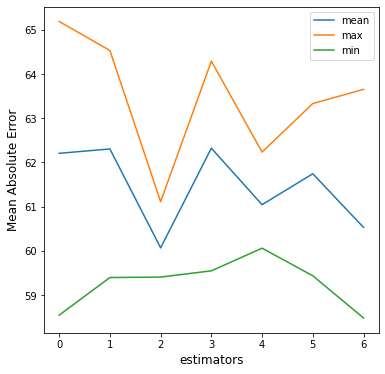

In [61]:
# transpose and de-transpose df
transpose_df = pd.DataFrame(cv_scores).T.describe()
de_transpose_df = transpose_df.T

# plot results
fig, ax = plt.subplots(figsize=(6, 6))

# setting the axis' labels
ax.set_ylabel('Mean Absolute Error',fontsize=12)
ax.set_xlabel('estimators',fontsize=12)
ax.set_xticks(de_transpose_df.index.to_list())

# plot a line for mean, max, min
de_transpose_df[['mean','max','min']].plot(ax=ax);